# Face Recognition Using Higher Order SVD (Tensorfaces Algorithm)

---
#### Course: Computational Data Mining
#### Professor: Dr. Fatemeh Shakeri
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### December 2023

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Importing the Dataset](#dataset)
  - [Downloading the Dataset](#download)
  - [Importing File Addresses](#address)
  - [Importing Images into a Tensor](#tensor)
- [Implementations](#implement)
  - [Folding](#fold)
  - [Unfolding](#unfold)
  - [Multiplication](#multiply)
  - [Higher-Order SVD](#hosvd)
  - [Classifier](#classifier)
- [Applying the Classifier](#apply)
- [Visualization & Final Conclusion](#conclusion)

<a name="intro"></a>

# Introduction 📚

---

One of the important tasks in computer vision and image processing  face recognition, where we are supposed to come up with a model that learns features of faces that are present in a dataset and then use its knowledge to recognize the identity of a new test face.

<img src="https://raw.githubusercontent.com/serengil/deepface/master/icon/stock-1.jpg" width="400"/>

There are several naive and sophisticated solutions for this problems, from the classic algorithms such as Eigenfaces, to the most modern ones such as Convolutional neural networks.

In this article, we utilize the Higher-Order Singular Value Decomposition, or HOSVD in short, to recognize identity of faces along their predefined situitations such as happiness, sad or different light settings. Our method is similar to the Eigenfaces algorithm, but with 2 main differences:

1. The Eigenfaces algorithm does not take into account the emotion or photographic situitations of the image.

2. The Eigenfaces algorithm is implemented on a matrix of faces, where each column is a image of a face, but here we will consider a 3D tensor, where each column is an image, and each vertical layer of our tensor is a set of images of a single person.

<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **pandas**: <br />
    pandas is well-known in data science for its useful methods for reading and manipulating the data.

- **matplotlib**: <br />
    matplotlib is a super useful python library for drawing charts and data visualization. We use it to plot our facial images.

- **seaborn** : <br />
    seaborn is built on matplotlib and provides many chart templates for us so we don't need to draw and build every components of our charts with matplotlib. We will use it to plot the final confusion matrix.

- **PIL** :
    PIL or Pillow library is a common well-known library for image processing. It helps us to read, manipulate and save images. We will use it together with OpenCV.


In [ ]:
%%capture
# Python Standard Libraries
import os
import math
import random
# Fundamental Data Analysis & Visualization Tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

<a name="dataset"></a>

#Importing the Dataset 🔽

---

Here we download the dataset of facial images from my google drive, then we import it using the pandas library.

<a name="download"></a>

###Downloading the Dataset

---

Here we download the dataset of facial images from my google drive, then we import it using the pandas library.

In [ ]:
%%capture
# Downloading the dataset
!gdown '1LuEMbkvGVjZHVSr0saciNfZF4SKHiM0I'

Now, we unzip this file to get the folder containing train and test images.

In [ ]:
%%capture
# Unzipping the datafile
!unzip YALE_faces.zip

<a name="address"></a>

###Importing File Addresses

---

Next, we must import address of each train and test image from train and test folders that are present inside our dataset folder...

In [ ]:
# Defining Directories
train_dr = os.path.join('YALE_faces', 'train')
test_dr = os.path.join('YALE_faces', 'test')
# Browsing Train Directory
train_paths = [os.path.join(train_dr,addr) for addr in os.listdir(train_dr)]
# Browsing Test Directory
test_paths = [os.path.join(test_dr,addr) for addr in os.listdir(test_dr)]
# Print Success Message
print('Successfully Imported Addresses!')

Successfully Imported Addresses!


Lets demonstrate a random photo for a quick preview!

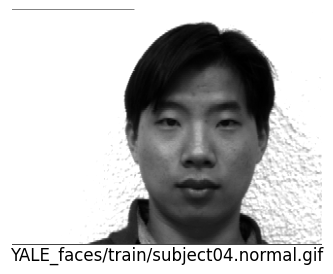

In [ ]:
# Selecting a Random Image
img_addr = random.choice(train_paths)
sample_img = np.array(Image.open(img_addr))
# Displaying the Image
plt.figure(figsize=(4,8))
plt.axis('off')
plt.title(f'{img_addr}', y=-0.1)
plt.imshow(sample_img, cmap='gray')

Additionally, lets see how each image is represented in a numpy format:

In [ ]:
print(f'Image shape: {sample_img.shape}')
print(f'Total #Elements: {math.prod(sample_img.shape)}')

Image shape: (243, 320)
Total #Elements: 77760


So each image is a 243 x 320 matrix with 77760 elements in total. We will use this piece of information in the section to stack vectors of our images and build a 3D tensor.

<a name="tensor"></a>

###Importing Images into a Tensor

---

-> According to the class notation, A(:, :, p) shows all images of a single person in different settings, and A(:, e, :) and shows image of all people in an emotion or a setting, where A is our 3D tensor of images. Here, we construct this 3D tensor and additionally, we keep order of subjects and emotion in two different lists named "subjs" and "emos".

In [ ]:
# Defining lists for subject and emotion labels of train images
train_emos = list(set([addr.split(os.sep)[-1].split('.')[1] for addr in train_paths]))
train_subjs = list(set([addr.split(os.sep)[-1].split('.')[0] for addr in train_paths]))

# Constructing the tensor of train images
A = np.zeros((77760, len(train_emos), len(train_subjs)))
for path in train_paths:
    filename = path.split(os.sep)[-1]
    emo_index = train_emos.index(filename.split('.')[1])
    subj_index = train_subjs.index(filename.split('.')[0])
    A[:, emo_index, subj_index] = np.array(Image.open(path)).flatten()

# Defining lists for subject and emotion labels of test images
test_emos = []
test_subjs = []

# Constructing the tensor of test images
test_imgs = np.zeros((77760, len(test_paths)))
for i, path in enumerate(test_paths):
    filename = path.split(os.sep)[-1]
    test_emos.append(filename.split('.')[1])
    test_subjs.append(filename.split('.')[0])
    test_imgs[:, i] = np.array(Image.open(path)).flatten()

Now, that we have made tensor of train and test images, lets reconstruct one of the images from this tensor to validate its data...

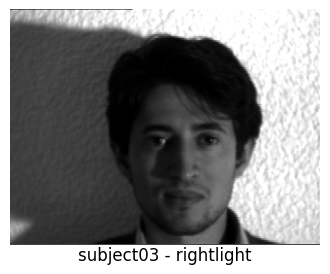

In [ ]:
plt.figure(figsize=(4,8))
plt.axis('off')
plt.title(f'{train_subjs[0]} - {train_emos[0]}', y=-0.1)
plt.imshow(A[:, 0, 0].reshape((243, 320)), cmap='gray')
# Uncomment this part to display a test image
# plt.title(f'{test_subjs[0]} - {test_emos[0]}', y=-0.1)
# plt.imshow(test_imgs[:, 0].reshape((243, 320)), cmap='gray')

Sounds great! Now lets proceed to the next section.

<a name="implement"></a>

#Implementations 🧨

---

Now, in this section, we will implement the following methods:
  - [Fold](#fold)
  - [Unfold](#unfold)
  - [Multiplication](#multiply)
  - [Higher-Order SVD](#hosvd)
  - [Classifier](#classifier)

Numpy represent elements of a 3D tensor in the format of A\[depth]\[row]\[column] but according to the class materials, we prefer to represent our elements in the format of A\[row]\[column]\[depth]. Therefore, We implement first three methods in two different ways:

1. Approach 1: </br>
    In this approach, we assume that our tensors are represented in the format of A\[row]\[column]\[depth]. (Representation of the class)

2. Approach 2: </br>
    In this approach, we assume that our tensors are represented in the format of A\[depth]\[row]\[column]. (Default representation of numpy)

Please remember that we only implement methods in second approach, although I have tested these methods in both formats, but we only use methods of the first approach. Feel free to test and use methods of the second approach.

<a name="fold"></a>

###Folding

---

Let's implement three different modes of folding...


In [ ]:
# -------------------- Approach 1 --------------------
def fold(A, mode, shape):
    if A.shape[0] != shape[mode-1]:
        raise ValueError('#Rows must be = value of shape[mod-1]')

    n, m = A.shape
    if mode == 1:
        return np.stack([row.reshape((shape[1],shape[2])) for row in A])

    if mode == 2:
        return np.rot90(np.rot90(
            np.stack([A[:, shape[0]*i:shape[0]*(i+1)].T for i in range(shape[2])])
            , axes=(2,1)), axes=(0,2))

    if mode == 3:
        return np.rot90(np.rot90( np.stack([row.reshape(shape[0], shape[1]) for row in A]),
         axes=(2,1)), axes=(0,2))
# ----------------------------------------------------

# -------------------- Approach 2 --------------------
# def fold(A, mode, shape):
#     n, m, k = shape
#     if mode == 1:
#         return np.stack([A[:, n*i:n*(i+1)].T for i in range(k)], axis=2)

#     if mode == 2:
#         return np.stack([A[:, m*i:m*(i+1)].T for i in range(n)])

#     if mode == 3:
#         return A.reshape(shape)
# ----------------------------------------------------

Now let's validate performance of our folding method with some examples from the class...

In [ ]:
print('\nFold - Mode 1:')
X = np.array([[-1, 0, -4, 0, -1, -5, -2, -3, 0],
              [-1, 2, -7, -1, 0, -8, -5, -7, -2],
              [5, 6, 11, -3, 8, 16, 1, 3, -6]])

print(fold(X, mode=1, shape=(3,3,3)))
print('Output shape: ', fold(X, mode=1, shape=(3,3,3)).shape)

print('\nFold - Mode 2:')
X = np.array([[1, 2, 2, 0, -3, -1],
              [-2, 5, -7, 3, 9, -4],
              [4, 5, 9, -1, -13, -2]])

print(fold(X, mode=2, shape=(2,3,3)))
print('Output shape: ', fold(X, mode=2, shape=(2,3,3)).shape)

print('\nFold - Mode 3:')
X = np.array([[2, 3, 1, -1, 0, -2],
              [2, 2, 1, 1, 0, -5],
              [12, 21, 6, -12, 0, -3]])

print(fold(X, mode=3, shape=(2, 3, 3)))
print('Output shape: ', fold(X, mode=3, shape=(2, 3, 3)).shape)


Fold - Mode 1:
[[[-1  0 -4]
  [ 0 -1 -5]
  [-2 -3  0]]

 [[-1  2 -7]
  [-1  0 -8]
  [-5 -7 -2]]

 [[ 5  6 11]
  [-3  8 16]
  [ 1  3 -6]]]
Output shape:  (3, 3, 3)

Fold - Mode 2:
[[[  1   2  -3]
  [ -2  -7   9]
  [  4   9 -13]]

 [[  2   0  -1]
  [  5   3  -4]
  [  5  -1  -2]]]
Output shape:  (2, 3, 3)

Fold - Mode 3:
[[[  2   2  12]
  [  3   2  21]
  [  1   1   6]]

 [[ -1   1 -12]
  [  0   0   0]
  [ -2  -5  -3]]]
Output shape:  (2, 3, 3)


Our method works properly!

<a name="unfold"></a>

###Unfolding

---

Let's implement three different modes of unfolding, Assume that A is of shape nxmxk:
- Mode 1 : [A(:, 0, :), A(:, 1, :), ..., A(:, m-1, :)]
  
- Mode 2 : [A(:, :, 0), A(:, :, 1), ..., A(:, :, k-1)]
  
- Mode 3 : [A(0, :, :), A(1, :, :), ..., A(n-1, :, :)]

In [ ]:
# -------------------- Approach 1 --------------------
def unfold(A, mode):
    n, m, k = A.shape
    if mode == 1:
        return A.reshape(n, -1)
    if mode == 2:
        return np.vstack([A[:, :, i] for i in range(k)]).T
    if mode == 3:
        return np.vstack([A[i, :, :] for i in range(n)]).T
# ----------------------------------------------------

# -------------------- Approach 2 --------------------
# def unfold(A, mode):
#     n, m , k = A.shape
#     if mode == 1:
#         return np.vstack([A[:, :, i] for i in range(k)]).T

#     if mode == 2:
#         return np.hstack([A[i, :, :].T for i in range(n)])

#     if mode == 3:
#         return np.vstack([A[i, :, :].flatten() for i in range(n)])
# ----------------------------------------------------

Now let's test our method with an example from the class to make sure that it works properly...

In [ ]:
X = np.array( [[[4,0,10],
                [2,-2,1]],

               [[-3,1,5],
                [0,-1,2]],

               [[0,3,-1],
                [-6,4,4]],

               [[-1,5,-2],
                [1,-4,0]]] )

print(f'shape of X: {X.shape}')

print('\nUnfold - Mode 1:')
print( unfold(X, 1) )

print('\nUnfold - Mode 2:')
print( unfold(X, 2) )

print('\nUnfold - Mode 3:')
print( unfold(X, 3) )

shape of X: (4, 2, 3)

Unfold - Mode 1:
[[ 4  0 10  2 -2  1]
 [-3  1  5  0 -1  2]
 [ 0  3 -1 -6  4  4]
 [-1  5 -2  1 -4  0]]

Unfold - Mode 2:
[[ 4 -3  0 -1  0  1  3  5 10  5 -1 -2]
 [ 2  0 -6  1 -2 -1  4 -4  1  2  4  0]]

Unfold - Mode 3:
[[ 4  2 -3  0  0 -6 -1  1]
 [ 0 -2  1 -1  3  4  5 -4]
 [10  1  5  2 -1  4 -2  0]]


Awesome! Our method works properly.

<a name="multiply"></a>

###Multiplication

---

Next, we implement the multiplication operator. It is straight forward because we rely on numpy standard multiplier and our previous methods.

In [ ]:
# -------------------- Approach 1 --------------------
def multiply(A, U, mode):
    if mode in [1, 2, 3]:
        shape = list(A.shape)
        shape[mode-1] = U.shape[0]
        return fold(U @ unfold(A, mode), mode=mode, shape=shape)
# ----------------------------------------------------

# -------------------- Approach 2 --------------------
# def multiply(A, U, mode):
#     if mode in [1, 2, 3]:
#         shape = list(A.shape)
#         shape[mode%3] = U.shape[0]
#         return fold(U @ unfold(A, mode), mode=mode, shape=shape)
# ----------------------------------------------------

Now, let's test our method with an example from the class...

In [ ]:
print('\nMultiplication - Mode 1 example: ')
X = np.array( [[[1,0,4], [0,1,5], [2,3,0]], [[1,2,1],[-1,2,2],[-1,-1,-2]]] )
U = np.array([[-1, 0], [-2, 1], [2, 3]])
print(multiply(X, U, mode=1))
print(f'{X.shape} x_mode1 {U.shape} -> {multiply(X, U, mode=1).shape}')

print('\nMultiplication - Mode 2 example')
X = np.array( [[[1,2,-3], [0,-1,1]], [[2,0,-1], [3,1,-2]]] )
V = np.array( [[1,0], [-2,3], [4,-1]] )
print(multiply(X, V, mode=2))
print(f'{X.shape} x_mode2 {V.shape} -> {multiply(X, V, mode=2).shape}')

print('\nMultiplication - Mode 3 example')
X = np.array( [[[2,2], [3,4], [1,1]], [[-1,-3], [0,0], [-2,1]]] )
W = np.array( [[1,0], [2,-1], [3,3]] )
print(multiply(X, W, mode=3))
print(f'{X.shape} x_mode3 {W.shape} -> {multiply(X, W, mode=3).shape}')


Multiplication - Mode 1 example: 
[[[-1  0 -4]
  [ 0 -1 -5]
  [-2 -3  0]]

 [[-1  2 -7]
  [-1  0 -8]
  [-5 -7 -2]]

 [[ 5  6 11]
  [-3  8 16]
  [ 1  3 -6]]]
(2, 3, 3) x_mode1 (3, 2) -> (3, 3, 3)

Multiplication - Mode 2 example
[[[  1   2  -3]
  [ -2  -7   9]
  [  4   9 -13]]

 [[  2   0  -1]
  [  5   3  -4]
  [  5  -1  -2]]]
(2, 2, 3) x_mode2 (3, 2) -> (2, 3, 3)

Multiplication - Mode 3 example
[[[  2   2  12]
  [  3   2  21]
  [  1   1   6]]

 [[ -1   1 -12]
  [  0   0   0]
  [ -2  -5  -3]]]
(2, 3, 2) x_mode3 (3, 2) -> (2, 3, 3)


All three modes work properly!

<a name="hosvd"></a>

###Higher-Order SVD

---

Finally, we implement a method for Higher-Order Singular Value Decomposition (aka HOSVD). In this decompostion, we decompose our tensor A into a tensor S and three matrices:

> A = S  x_mode1  U1  x_mode2  U2  x_mode3  U3

where S is equal to:

> S = A  x_mode1  U1.T  x_mode2  U2.T  x_mode3  U3.T

In [ ]:
def HOSVD(A):
    U_mats = [np.linalg.svd(unfold(A, mode), full_matrices=False)[0] for mode in range(1, 4)]
    S = A.copy()
    for i, U in enumerate(U_mats, start=1):
        S = multiply(S, U.T, mode=i)
    return S, U_mats

Now let's test this method with a sample tensor. (1) Two  tensors, A & S, must hold the previous equation and each layer of S in each dimension must be orthogonal to other layers.

Here, we only test the first condition and the second condition holds due to the fact that we calculate U matrices using SVD of unfolded version of our tensor in different modes.

In [ ]:
X = np.array( [[[2,2], [3,4], [1,1]], [[-1,-3], [0,0], [-2,1]]] )
# Calculating the HOSVD
S, Us = HOSVD(X)
# Checking the first equation
s = S.copy()
for i, U in enumerate(Us, start=1):
    s = multiply(s, U, mode=i)
# Calculating the frobenius norm of difference of X and S
print(' Norm of the residual tensor: ', np.sqrt((X - s) ** 2).sum())

 Norm of the residual tensor:  2.7381839429922434e-14


Awesome! Calculated S applies to the first equation.

<a name="classifier"></a>

###Classifier

---

Before going to the next section, let's define a method that takes a test image and predicts emotion and subject for the given image.

Class materials proposed to solve a least squares problem for each C[:, e, :] and proposed another method to decrease the necessary computation for this problem. However, I calculate pseudo inverse of each C[:, e, :] and apply them in testing stage to solve this least square problems, in this way, we reduce the solving of each LSP to a single matrix multiplication. I am well aware that calculating the pseudo inverse of a matrix may not be computationally stable and may have more error that directly solving LSPs, but some level numerical error is acceptable in our computation and do not change our predictions.

In [ ]:
def classify(img, Cpinv, H, threshold):
    alphas = Cpinv @ img
    dists = np.linalg.norm((H[:, :, np.newaxis] - alphas), ord=2, axis=1)
    min_index = np.unravel_index(dists.argmin(), dists.shape)
    # Checking threshold
    if dists[min_index] <= threshold:
        return min_index
    else:
        return -1, -1

Let's test this method on a sample image from our training images to validate its performance...

In [ ]:
# Calculating HOSVD of the tensor A
S, Us = HOSVD(A)
F, G, H = Us
# Calculating the tensor C
C = multiply(multiply(S, F, mode=1), G, mode=2)
# Calculating the pseudo inverse of each C[:, e, :]
Cpinv = np.stack([np.linalg.pinv(C[:, e, :]) for e in range(C.shape[1])], axis=1)

In [ ]:
# Printing the real subject and emotion labels
print('Real subject and emotion: ', (train_subjs[2], train_emos[2]))
# Printing the predicted subject and emotion labels
subj, emo = classify(A[:, 2, 2], Cpinv, H, threshold=10)
print('Predicted subject and emotion: ', (train_subjs[subj], train_emos[emo]))

Real subject and emotion:  ('subject10', 'sleepy')
Predicted subject and emotion:  ('subject10', 'sleepy')


<a name="apply"></a>

#Applying the Classifier

---

In this section, we apply our classifier method to predict subjects and emotions for test images.

First, we define two confusion matrices, one for subjects and another one for emotions. Then, we predict subject and emotion for each test image and fill our confusion matrices.

Unfortunately, only "exist" and "not_exist" labels are provided for emotion of test images, therefore we will define a 2x2 confusion matrix for emotions...

In [ ]:
# Defining confusion matrices
emo_conf_mat = np.zeros((2, 2))
subj_conf_mat = np.zeros((len(train_subjs) + 1, len(train_subjs) + 1))
# Iterating over test images
for col in range(test_imgs.shape[1]):
    # Predicting labels
    pred_subj, pred_emo = classify(test_imgs[:, col], Cpinv, H, threshold=0.54) # Feel free to change the threshold
    if pred_emo != -1:
        pred_emo = 1

    # Extracting real labels
    real_emo = int(test_emos[col] == 'exist')
    if real_emo == 1:
        real_subj = train_subjs.index(test_subjs[col])
    else:
        real_subj = -1

    # Adding values to the confusion matrices
    emo_conf_mat[ real_emo][ int(pred_emo >= 0) ] += 1
    subj_conf_mat[real_subj][pred_subj] += 1

I found the best threshold to be "0.54". Feel free to change the specified threshold to test the performance of our classifier.

<a name="conclusion"></a>

# Visualization & Final Conclusion

---

Finally, we plot our confusion matrices:

[Text(0.5, 1.0, 'Confusion Matrix for Emotions')]

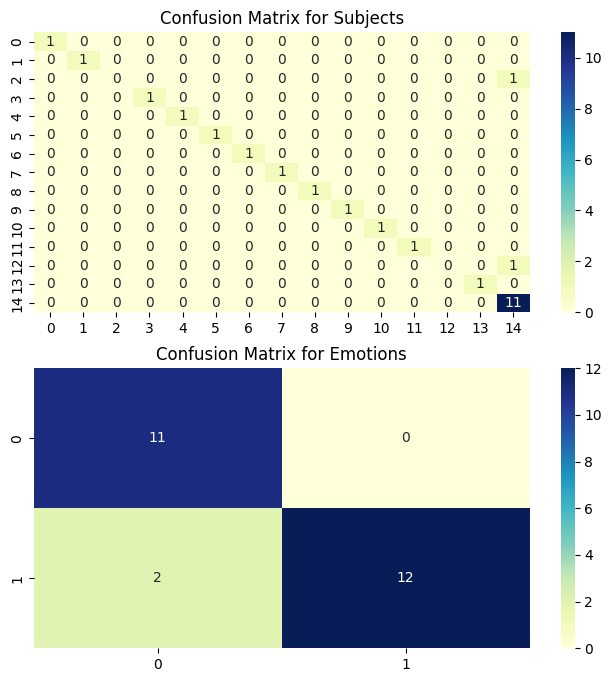

In [ ]:
# Plotting our confusion matrices
plt.figure(figsize=(8, 8))
# Plotting the confusion matrix for subjects
plt.subplot(2, 1, 1)
sns.heatmap(subj_conf_mat, annot=True, cmap='YlGnBu').set(title="Confusion Matrix for Subjects")
# Plotting the confusion matrix for emotions
plt.subplot(2, 1, 2)
sns.heatmap(emo_conf_mat, annot=True, cmap='YlGnBu').set(title="Confusion Matrix for Emotions")

Out of 25 test images, our model correctly predicted labels of 23 test images! It not just predicted the existence of the person in our dataset, but also predicted the emotion of 23 test images that their person existed in our dataset...

Overall, it seems that this method shows a much better performance in compared to the Eigenfaces method. This is not surprising, because we have utilized more data and used more computational resources. But developing a model that wisely uses computational resources and shows better performance in return is a valuable achievement.


Thanks for you valuable time and attention! This notebook is available in the link below😀

https://drive.google.com/file/d/1_USQKnoADpOcZQCL4rFXCGWjFPS3ORoP/view?usp=sharing